# Variabilité interannuelle : étude de l'oscillation nord Atlantique

**Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2022**

**L'oscillation nord Atlantique (NAO)** se caractérise par une oscillation du champ moyen de pression réduite au niveau de la mer dans la région Atlantique nord. Elle a été découverte durant les années 1920 par Sir Gilbert Walker, qui avait découvert précédemment l’oscillation australe dans l'océan Pacifique et à laquelle est relié le phénomène El Niño (ENSO). Comme l’ENSO la NAO est un facteur climatique déterminant à l'échelle régionale car elle impacte la position et la trajectoire des perturbations qui touchent l'Europe de l'Ouest ainsi que les températures océaniques du bassin Atlantique nord.

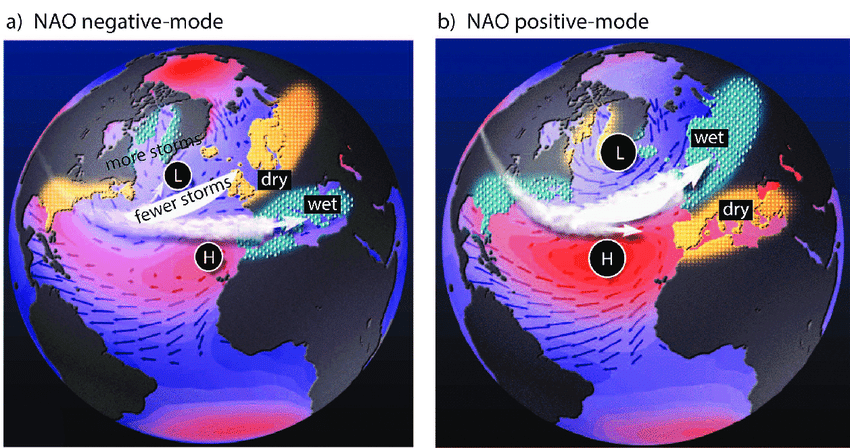


**Phase positive NAO+** : anomalie positive de Pmer aux latitudes subtropicales et anomalie négative aux latitudes septentrionales. renforcement de la circulation zonale d’ouest sur le bassin Atlantique et l’Europe occidentale, décalage vers le Nord de la zone barocline.

**Phase négative NAO-** : anomalie négative s’étendant des Açores au bassin méditerranéen occidental, anomalie positive s’étirant du Groenland à la mer du Nord. Zone barocline moins marquée et plus au sud.

- Partie 1 : étude de l'indice station NAO période DJFM
- Partie 2 : étude des réanalyses ERA5 DJFM sur l'Atlantique nord
- Partie 3 : Lisbon VS Stykkisholmur et analyse en composantes principales
- Partie 4 : analyse en composantes principales sur les cartes d'anomalies
- Partie 5 : comparaison de l'indice NAO station et de l'indice NAO obtenu par ACP
- Partie 6 : classification Kmeans dans l'espace des PCs

Concepts Python illustrés :

- Etude de séries temporelles (pandas)
- Exploitation de fichiers netcdf (xarray)
- Calcul de climatologies et d'anomalies
- Tracé de cartes (cartopy)
- Analyse en composantes principales (eofs)
- Classification automatique Kmeans (sklearn)

In [ ]:
import os

import numpy as np

import pandas as pd
from pandas import Series

import xarray as xr
from netCDF4 import Dataset

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.path as mpath

from eofs.standard import Eof
from sklearn.cluster import KMeans

In [ ]:
dir_data='./data/'
dir_figs='./figs/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)

# Partie 1 : étude de l'indice NAO

L'indice NAO (https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based) quantifie les variations de pression réduite au niveau de la mer en hiver entre les latitudes subtropicales et les latitudes subpolaires. Cet indice est calculé en faisant la différence des anomalies de Pmer entre Lisbonne (Portugal) et Stykkisholmur (Islande). Afin d'éviter que l'indice soit dominé par la plus grande variabilité de la station de Stykkisholmur, les anomalies sont normalisées i.e. pour chaque station, on soustrait la moyenne temporelle et on divise par l'écart type (période de référence 1864-1983).

In [ ]:
nao_file=dir_data+'nao_station_djfm_0.txt'

X, Y = [], []
for line in open(nao_file, 'r'):
    values = [float(s) for s in line.split()]
    X.append(values[0])
    Y.append(values[1])

print(X)
print(Y)

In [ ]:
year1 = int(X[0])
year2 = int(X[-1])

fig=plt.figure(figsize=(15, 8))
fig.suptitle('NAO station-based index : DJFM '+str(year1)+'-'+str(year2), fontsize=16)
plt.title('Data : https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based',
          fontsize=12, color='grey')
plt.xlabel('Year')
plt.ylabel('Normalized pressure difference (Lisbon - Stykkisholmur)')

plt.xlim(year1, year2)
plt.ylim(-5, 5.5)
xi = [i for i in range(year1, year2,4)]
plt.xticks(xi, range(year1, year2,4))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

Y2=np.asarray(Y)
colormat=np.where(Y2>0, 'red','blue')
plt.bar(X, Y2, width=0.5, color=colormat)
plt.axhline(0, color='k')
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(4, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-4, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(1980, color='black', linestyle='--', linewidth=1)
plt.axvline(1990, color='black', linestyle='--', linewidth=1)
plt.axvline(2000, color='black', linestyle='--', linewidth=1)
plt.axvline(2010, color='black', linestyle='--', linewidth=1)

plt.show()

figname=dir_figs+'nao_index_'+str(year1)+'-'+str(year2)
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
nao_index=np.loadtxt(nao_file)

nao_dates=nao_index[:,0]
nao_index=nao_index[:,1:]
nao_index=nao_index.flatten()

dates = pd.date_range(str(year1), str(year2), freq='AS')
nao_index = Series(nao_index, index=dates)
print(nao_index)

nao_index_smooth=nao_index.rolling(window=10, center=True).mean()
print(nao_index_smooth)

In [ ]:
fig=plt.figure(figsize=(15, 8))
fig.suptitle('NAO station-based index : DJFM '+str(year1)+'-'+str(year2), fontsize=16)
plt.title('Data : https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based' , fontsize=12, color='grey')
plt.xlabel('Year')
plt.ylabel('Normalized pressure difference (Lisbon - Stykkisholmur)')

ax = nao_index.plot(color='grey', linewidth=0.5, alpha=1, label='NAO index')
ax = nao_index_smooth.plot(color='red', linewidth=2, label='10-month RM NAO ondex')

plt.axhline(0, color='k')
plt.axhline(1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(3, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-3, color='grey', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

figname=dir_figs+'nao_index_smooth_'+str(year1)+'-'+str(year2)
fig.savefig(figname+'.png', bbox_inches='tight')

# Partie 2 : étude des données ERA5

Données de départ : climatologies mensuelles ERA5 de la pression réduite au niveau de la mer :
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form

Les données ont été préalablement traitées avec CDO (https://code.mpimet.mpg.de/projects/cdo/) afin de ne garder que des moyennes sur les mois DJFM pour le domaine Atlantique nord :
- cdo sellonlatbox,-100,40,20,80 era5.mslp.mon.mean.nc era5.mslp.mon.mean.atl.nc
- cdo timselmean,4,11,8 era5.mslp.mon.mean.atl.nc era5.mslp.djfm.mean.atl.nc

--> fichier era5.mslp.djfm.mean.natl.nc (moyennes DJFM de la Pmer sur l'Atlantique nord - période 1960-2021).

In [ ]:
nc_file = dir_data+'era5.mslp.djfm.mean.natl.nc'

data    = xr.open_dataset(nc_file)
print(data)

In [ ]:
latS=20
latN=80
lonW=-80
lonE=30
yr1 = '1981'
yr2 = '2020'

data    = xr.open_dataset(nc_file).sel(latitude=slice(latN,latS)).sel(longitude=slice(lonW,lonE)).sel(time=slice(yr1,yr2))
data_clim = data.mean('time')
print(data)
print(data_clim)
lat  = data.latitude.values
lon  = data.longitude.values
time  = data.time.values

#--  Manage dates
time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]
for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:10]

print(date_str)

slp, slp_clim, = xr.broadcast(data['msl']/100, data_clim['msl']/100)
slp_anom=(slp-slp_clim)
print(slp.shape)
print(slp_clim.shape)
print(slp_anom.shape)

In [ ]:
levels = np.arange(980,1042,2)
levels_a = np.arange(-16,18,2)

In [ ]:
projection = ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)
Lisbon = [-9, 39]
Stykkisholmur = [-22.5, 65]

def plot_background(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    return ax

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

def plot_town(ax):
    ax.plot(Lisbon[0], Lisbon[1], marker='o', color='red', markersize=8,
            alpha=0.7, transform=ccrs.PlateCarree())
    ax.text(Lisbon[0], Lisbon[1], u'Lisbon',
            verticalalignment='center', horizontalalignment='right',
            transform=ccrs.PlateCarree()._as_mpl_transform(ax),
            bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
    ax.plot(Stykkisholmur[0], Stykkisholmur[1], marker='o', color='red', markersize=8,
            alpha=0.7, transform=ccrs.PlateCarree())
    ax.text(Stykkisholmur[0], Stykkisholmur[1], u'Stykkisholmur',
            verticalalignment='center', horizontalalignment='right',
            transform=ccrs.PlateCarree()._as_mpl_transform(ax),
            bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))

In [ ]:
fig = plt.figure(figsize=(15., 10.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Mean Sea Level Pressure (hPa) - DJFM '+ yr1+'-'+yr2, loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, slp_clim[0,:,:], levels, cmap='jet', transform=ccrs.PlateCarree(), extend='both')
c = ax.contour(lon, lat, slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05, extendrect='True')
cb.set_label('hPa', size='large')

plt.show()

figname=dir_figs+'mslp_clim_DJFM_atl_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(16,6))
fig.suptitle('Mean Sea Level Pressure (hPa) - DJFM', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 8),
       axes_pad=0.2,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background(ax)
    ax.set_title(date_str[i][0:4], fontsize=10)
    p1 = ax.contourf(lon, lat, slp[i,:,:], levels, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    p2 = ax.contour(lon, lat, slp[i,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname=dir_figs+'mslp_DJFM_atl_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(16,6))
fig.suptitle('DJFM Mean sea level pressure anomaly (hPa)', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 8),
       axes_pad=0.2,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    plot_background(ax)
    ax.set_title(date_str[i][0:4], fontsize=10)
    p1 = ax.contourf(lon, lat, slp_anom[i,:,:], levels_a, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
    p2 = ax.contour(lon, lat, slp_anom[i,:,:], levels_a, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname=dir_figs+'mslp_anom_DJFM_atl_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

# Partie 3 : Lisbon VS Stykkisholmur et analyse en composantes principales

Méthode d'analyse en composantes principales (ACP, Empirical Orthogonal Function, EOF analysis) : méthode statistique permettant de simplifier des données spatio-temporelles en les décomposant structures spatiales de variabilité et en projections temporelles de ces structures. Les vecteurs propres (EOFs) sont des fonctions de base en terme de variance. Les projections temporelles associées sont les composantes principales (PCs) et correspondent aux coefficients temporels des EOFs. On utilisera ici le package Python eofs : https://ajdawson.github.io/eofs/latest/

In [ ]:
ilat1 = list(lat).index(Lisbon[1])
ilon1 = list(lon).index(Lisbon[0])
slp_anom_Lisbon = slp_anom[:,ilat1,ilon1]
slp_anom_Lisbon_norm = (slp_anom_Lisbon-np.mean(slp_anom_Lisbon))/np.std(slp_anom_Lisbon)

ilat1 = list(lat).index(Stykkisholmur[1])
ilon1 = list(lon).index(Stykkisholmur[0])
slp_anom_Stykkisholmur = slp_anom[:,ilat1,ilon1]
slp_anom_Stykkisholmur_norm = (slp_anom_Stykkisholmur-np.mean(slp_anom_Stykkisholmur))/np.std(slp_anom_Stykkisholmur)

In [ ]:
fig = plt.figure(figsize=(25, 8))
fig.suptitle('Stykkisholmur and Lisbon MSLP anomalies : DJFM '+yr1+'-'+yr2, fontsize=14)
ax = fig.add_subplot(121, projection=projection)
plt.title('', fontsize=10, loc='center')
plot_background(ax)
ax.set_extent([-80, 20, 20, 80])

plot_town(ax)

ax = fig.add_subplot(122)
plt.title('' , fontsize=12, color='grey')
plt.xlabel('Year')
plt.ylabel('MSLP anomaly (hPa)')
yrs = range(int(yr1), int(yr2)+1)
xi = [i for i in range(int(yr1), int(yr2)+1,2)]
ax.plot(yrs, slp_anom_Stykkisholmur, color='red', linewidth=2, label='Stykkisholmur')
ax.plot(yrs, slp_anom_Lisbon, color='blue', linewidth=2, label='Lisbon')

plt.axhline(0, color='k')
plt.legend()
plt.show()

figname=dir_figs+'Stykki_Lisbon_DJFM_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
def plot_phase_space(ax):
    plt.title('')
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel('MSLP anomaly at Stykkisholmur (hPa)')
    plt.ylabel('MSLP anomaly at Lisbon (hPa)')
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    return ax

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
fig.suptitle('Stykkisholmur and Lisbon MSLP anomalies scatterplot : DJFM '+yr1+'-'+yr2, fontsize=14)
plot_phase_space(ax)
#plt.scatter(slp_anom_Lisbon_norm, slp_anom_Stykkisholmur_norm)
plt.scatter(slp_anom_Stykkisholmur, slp_anom_Lisbon)
members = np.linspace(int(yr1), int(yr2), len(slp_anom_Stykkisholmur))
members_str =[str(i) for i in range(int(yr1),int(yr2)+1)]
for i,type in enumerate(members_str):
    x = slp_anom_Stykkisholmur[i]
    y = slp_anom_Lisbon[i]
    plt.text(x, y, type, fontsize=8)
plt.show()

figname=dir_figs+'Stykki_Lisbon_DJFM_scatterpot_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
print(slp_anom_Lisbon.shape)
slp_anom_array=np.transpose(np.vstack((slp_anom_Lisbon, slp_anom_Stykkisholmur)))
print(slp_anom_array.shape)

solver = Eof(slp_anom_array, center=True)

In [ ]:
eigenvalues = solver.eigenvalues()
total_variance = solver.totalAnomalyVariance()
varfrac = solver.varianceFraction()
eofs = solver.eofsAsCovariance()
pcs = solver.pcs()
pcs_norm = solver.pcs(pcscaling=1)

print(eofs.shape)
print(pcs.shape)

print('******** Nombre de valeurs propres **********')
print(eigenvalues.size)
print('******** valeurs propres **********')
print(eigenvalues)
print('******** variance totale (somme des valeurs propres) **********')
print(total_variance)
print('******** Variance PC1 **********')
print(np.var(pcs[:,0]))
print('******** Variance PC2 **********')
print(np.var(pcs[:,1]))
print('******** correlation PC1 PC2 **********')
cor_pc12=np.corrcoef(pcs[:,0], pcs[:,1])
print(round(cor_pc12[0,1],2))
print('******** pourcentage de variance EOF1 **********')
print(varfrac[0]*100)
print('******** pourcentage de variance EOF2 **********')
print(varfrac[1]*100)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('EOF analysis : MSLP DJFM '+yr1+'-'+yr2, fontsize=16)

eof_num = range(1, 3)
plt.bar(eof_num, varfrac[0:2], width=0.5)
plt.axhline(0, color='k')
plt.xticks(range(1, 3))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(0, 3)
plt.ylim(0, 1)
plt.show()

figname=dir_figs+'Stykki_Lisbon_DJFM_EOF_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
def plot_phase_space(ax):
    plt.title('Explained variance : EOF1 : '+str(round(varfrac[0]*100,1))+'- EOF2 : '+str(round(varfrac[1]*100,1)))
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel('PC1 : projection on EOF1')
    plt.ylabel('PC2 : projection on EOF2')
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    return ax

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
fig.suptitle('PC1 & PC2 scatterplot : DJFM '+yr1+'-'+yr2, fontsize=14)
plot_phase_space(ax)
plt.scatter(pcs[:,0], pcs[:,1])
for i,type in enumerate(members_str):
    x = pcs[i,0]
    y = pcs[i,1]
    plt.text(x, y, type, fontsize=8)
plt.show()

figname=dir_figs+'Stykki_Lisbon_DJFM_PCs_scatterplot_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
fig=plt.figure(figsize=(15, 8))
fig.suptitle('Projections on the EOFs (principal components) : DJFM '+yr1+'-'+yr2, fontsize=14)
plt.title('' , fontsize=12, color='grey')
plt.xlabel('Year')
plt.ylabel('MSLP anomaly (hPa)')
yrs = range(int(yr1), int(yr2)+1)
xi = [i for i in range(int(yr1), int(yr2)+1,2)]
plt.plot(yrs, pcs[:,0], color='red', linewidth=2, label='Projection on EOF1')
plt.plot(yrs, pcs[:,1], color='blue', linewidth=2, label='Projection on EOF2')

plt.axhline(0, color='k')
plt.legend()
plt.show()

figname=dir_figs+'Stykki_Lisbon_DJFM_PCs'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

# Partie 4 : analyse en composantes principales sur les cartes d'anomalies

Ici, les vecteurs propres (EOFs), fonctions de base en terme de variance, correspondent à des structures spatiales.

In [ ]:
wgts = np.sqrt(np.cos(np.deg2rad(lat)))[:, np.newaxis]

In [ ]:
solver = Eof(np.array(slp_anom), weights=wgts, center=True)
#solver = Eof(np.array(slp_anom), weights=None, center=False) # ACP sans pondération

In [ ]:
eigenvalues = solver.eigenvalues()
total_variance = solver.totalAnomalyVariance()
varfrac = solver.varianceFraction()
eofs = solver.eofsAsCovariance()
pcs = solver.pcs()
pcs_norm = solver.pcs(pcscaling=1)

print(eofs.shape)
print(pcs.shape)

print('******** Nombre de valeurs propres **********')
print(eigenvalues.size)
print('******** valeurs propres **********')
print(eigenvalues)
print('******** variance totale (somme des valeurs propres) **********')
print(total_variance)
print('******** Variance PC1 **********')
print(np.var(pcs[:,0]))
print('******** Variance PC2 **********')
print(np.var(pcs[:,1]))
print('******** Variance PC3 **********')
print(np.var(pcs[:,2]))
print('******** correlation PC1 PC2 **********')
cor_pc12=np.corrcoef(pcs[:,0], pcs[:,1])
print(round(cor_pc12[0,1],2))
print('******** pourcentage de variance EOF1 **********')
print(varfrac[0]*100)
print('******** pourcentage de variance EOF2 **********')
print(varfrac[1]*100)

In [ ]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('EOF analysis : MSLP DJFM '+yr1+'-'+yr2, fontsize=16)

eof_num = range(1, 16)
plt.bar(eof_num, varfrac[0:15], width=0.5)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
plt.show()

figname=dir_figs+'varfrac_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,10))
fig.suptitle('EOFs : MSLP DJFM '+yr1+'-'+yr2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

clevs = np.linspace(-8, 8, 21)
                   
for i, ax in enumerate(axgr):
    plot_background(ax)
    ax.set_title('EOF'+str(i+1)+' ('+str(int(varfrac[i]*100))+'%)', fontsize=10, loc='center')
    cf = ax.contourf(lon, lat, eofs[i], clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    c = ax.contour(lon, lat, eofs[i], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(cf)

plt.show()

figname=dir_figs+'eofs_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
years = np.arange(int(yr1), int(yr2)+1)
xi = [i for i in range(int(yr1), int(yr2)+1,5)]

def plot_pc(ax):
    plt.xlabel('Year')
    plt.axhline(0, color='k')
    plt.xlim(int(yr1), int(yr2)+1)
    plt.xticks(xi, range(int(yr1), int(yr2)+1,5))
    ax.axvline(1950, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1960, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1970, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1980, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1990, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(2000, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(2010, color='grey', linestyle='--', linewidth=0.5)
    plt.ylim(-1500, 1500)
    return ax

In [ ]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('PCs : MSLP DJFM '+yr1+'-'+yr2, fontsize=16)

ax = fig.add_subplot(411)
plt.ylabel('PC1')
plot_pc(ax)
colormat=np.where(pcs[:,0]>0, 'red','blue')
plt.bar(years, pcs[:,0], width=0.5, color=colormat)

ax = fig.add_subplot(412)
plt.ylabel('PC2')
plot_pc(ax)
colormat=np.where(pcs[:,1]>0, 'red','blue')
plt.bar(years, pcs[:,1], width=0.5, color=colormat)

ax = fig.add_subplot(413)
plt.ylabel('PC3')
plot_pc(ax)
colormat=np.where(pcs[:,2]>0, 'red','blue')
plt.bar(years, pcs[:,2], width=0.5, color=colormat)

ax = fig.add_subplot(414)
plt.ylabel('PC4')
plot_pc(ax)
colormat=np.where(pcs[:,3]>0, 'red','blue')
plt.bar(years, pcs[:,3], width=0.5, color=colormat)

plt.show()

figname=dir_figs+'pcs_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
reconstruction1 = solver.reconstructedField(1)
reconstruction2 = solver.reconstructedField(2)
reconstruction3 = solver.reconstructedField(3)
reconstruction4 = solver.reconstructedField(4)
reconstruction5 = solver.reconstructedField(5)
reconstruction6 = solver.reconstructedField(6)
reconstruction7 = solver.reconstructedField(7)
reconstruction8 = solver.reconstructedField(8)
reconstruction9 = solver.reconstructedField(9)
print(reconstruction1.shape)

In [ ]:
year='2011-01-16'
iyear = list(date_str).index(year)

In [ ]:
levels = np.arange(980,1042,2)
cmap='jet'

fig = plt.figure(figsize=(17,12))
fig.suptitle('Reconstructed Mean Sea Level Pressure (hPa) - DJFM '+ str(year)[0:4], fontsize=16)

ax = fig.add_subplot(4,3,2, projection=projection)
plot_background(ax)
ax.set_title('Full field', fontsize=14)
p1 = ax.contourf(lon, lat, slp[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, slp[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,4, projection=projection)
plot_background(ax)
ax.set_title('1 EOF', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction1[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction1[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,5, projection=projection)
plot_background(ax)
ax.set_title('2 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction2[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction2[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,6, projection=projection)
plot_background(ax)
ax.set_title('3 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction3[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction3[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,7, projection=projection)
plot_background(ax)
ax.set_title('4 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction4[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction4[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,8, projection=projection)
plot_background(ax)
ax.set_title('5 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction5[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction5[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,9, projection=projection)
plot_background(ax)
ax.set_title('6 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction6[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction6[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,10, projection=projection)
plot_background(ax)
ax.set_title('7 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction7[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction7[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,11, projection=projection)
plot_background(ax)
ax.set_title('8 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction8[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction8[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,12, projection=projection)
plot_background(ax)
ax.set_title('9 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction9[iyear,:,:]+slp_clim[0,:,:], levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
p2 = ax.contour(lon, lat, reconstruction9[iyear,:,:]+slp_clim[0,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

plt.show()

figname=dir_figs+'reconstruction_mslp_anom_DJFM_atl_'+str(year)[0:4]
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(20, 8))
fig.suptitle('EOF1 and PC1 : MSLP DJFM '+yr1+'-'+yr2, fontsize=16)
ax = fig.add_subplot(121, projection=projection)
plt.title('EOF1 ('+str(int(varfrac[0]*100))+'%)', fontsize=10, loc='center')
plot_background(ax)
plot_town(ax)
cf = ax.contourf(lon, lat, eofs[0], levels=clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
c = ax.contour(lon, lat, eofs[0], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')

ax = fig.add_subplot(122)
plt.ylabel('PC1')
plot_pc(ax)
colormat=np.where(pcs[:,0]>0, 'red','blue')
plt.bar(years, pcs[:,0], width=0.5, color=colormat)

plt.show()

figname=dir_figs+'eof1_pc1_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

# Partie 5 : comparaison de l'indice NAO station et de l'indice NAO obtenu par ACP

In [ ]:
pc1=pcs_norm[:,0]
print(pc1.shape)

XX=np.asarray(X)
YY=np.asarray(Y)
id=np.where((XX >= int(yr1)) & (XX <= int(yr2)))
nao_year=XX[id]
nao_index=YY[id]
print(nao_year.shape)
print(int(nao_year[0]))
print(int(nao_year[-1]))

cor=np.corrcoef(pc1, nao_index)

In [ ]:
fig = plt.figure(figsize=(15., 8.))
plt.title('Normalized PC1 VS NAO station-based index : '+yr1+'-'+yr2, loc='center')
plt.title('Correlation : '+str(round(cor[0,1],2)), loc='right')

plt.xlabel('Year')
plt.ylabel('Normalized Units')
yrs = range(int(yr1), int(yr2)+1)
xi = [i for i in range(int(yr1), int(yr2)+1,2)]
plt.plot(yrs, pc1, color='b', linewidth=2, label='PC1 from EOF analysis')
plt.plot(yrs, nao_index, color='r', linewidth=2, label='NAO index')
plt.axhline(0, color='k')
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.xlim(int(yr1), int(yr2)+1)
plt.xticks(xi, range(int(yr1), int(yr2)+1,2))
plt.ylim(-6, 6)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()

plt.show()

figname=dir_figs+'nao_index_vs_pc1'
fig.savefig(figname+'.png', bbox_inches='tight')

# Partie 6 : classification Kmeans dans l'espace des PCs

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
fig.suptitle('PC phase space', fontsize=14)
plot_phase_space(ax)
plt.xlim(-1500, 1500)
plt.ylim(-1500, 1500)
plt.title('MSLP DJFM '+yr1+'-'+yr2)
plt.scatter(pcs[:,0], pcs[:,1], s=10)
for i,type in enumerate(years):
    x = pcs[i,0]
    y = pcs[i,1]
    plt.text(x, y, type, fontsize=8)
plt.show()

figname=dir_figs+'PC1_PC2_DJFM_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
pcs = np.array([pcs[:,0],pcs[:,1]],)
pcs=pcs.transpose()

nclusters=2
kmeans = KMeans(n_clusters=nclusters)
kmeans = kmeans.fit(pcs)
cluster = kmeans.predict(pcs)
centroids = kmeans.cluster_centers_

print(cluster)
print(cluster.shape)
print(centroids)
print(centroids.shape)

In [ ]:
nc=[list(cluster[:]).count(i) for i in range(nclusters)]
freq=[round(x/cluster.shape[0]*100,2) for x in nc]
print(freq)

In [ ]:
color=[""]*len(cluster)
couleur=["blue","red"]
for i in range(len(cluster)):
    color[i]=couleur[cluster[i]]

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
fig.suptitle('Clustering in PC phase space', fontsize=14)
plot_phase_space(ax)
plt.xlim(-1500, 1500)
plt.ylim(-1500, 1500)
plt.title('MSLP DJFM '+yr1+'-'+yr2)
plt.scatter(pcs[:,0], pcs[:,1], c=color, s=10)
plt.scatter(centroids[:, 0], centroids[:, 1], c=couleur, s=200, alpha=1, marker='+')
for i,type in enumerate(years):
    x = pcs[i,0]
    y = pcs[i,1]
    plt.text(x, y, type, fontsize=8)
plt.show()

figname=dir_figs+'PC1_PC2_DJFM_clustering_'+yr1+'-'+yr2
fig.savefig(figname+'.png', bbox_inches='tight')

# Pour aller plus loin

Etude des régimes de temps de l'Atlantique nord (cf. calepin régimes de temps IENM1) :

- Première étape : Analyse en composantes principales des données quotidiennes quotidennes de Pmer ou de Z500.
- Deuxième étape : classification ("clustering") dans l'espace des 15 premiers EOFs.